#Usando GAN para gerar novos digitos

In [123]:
import os
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
import tensorflow as tf
from tensorflow import keras

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers import LeakyReLU
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import initializers

import warnings; warnings.simplefilter('ignore')

from io import BytesIO
import requests
import joblib

In [73]:
os.environ["KERAS_BACKEND"] = "tensorflow"

np.random.seed(42)
random_dim = 100

In [114]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5  
X_train = X_train.reshape(60000, 784)

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
otimizador = Adam(lr=0.0002, beta_1=0.5)

In [ ]:
gerador = Sequential()
gerador.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
gerador.add(LeakyReLU(0.2))

gerador.add(Dense(512))
gerador.add(LeakyReLU(0.2))

gerador.add(Dense(1024))
gerador.add(LeakyReLU(0.2))

gerador.add(Dense(784, activation='tanh'))
gerador.compile(loss='binary_crossentropy', optimizer=otimizador)

In [ ]:
discriminador = Sequential()
discriminador.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminador.add(LeakyReLU(0.2))
discriminador.add(Dropout(0.3))

discriminador.add(Dense(512))
discriminador.add(LeakyReLU(0.2))
discriminador.add(Dropout(0.3))

discriminador.add(Dense(256))
discriminador.add(LeakyReLU(0.2))
discriminador.add(Dropout(0.3))

discriminador.add(Dense(1, activation='sigmoid'))
discriminador.compile(loss='binary_crossentropy', optimizer=otimizador)

In [ ]:
def gerar_gan(discriminador, randomDim, gerador, otimizador):
  discriminador.trainable = False
  gan_input = Input(shape=(random_dim,))
  x = gerador(gan_input)

  gan_output = discriminador(x)
  gan = Model(inputs=gan_input, outputs=gan_output)
  gan.compile(loss='binary_crossentropy', optimizer=otimizador)

  return gan

In [ ]:
def salvar_digito_gerado(epoca, exemplos=25, dim=(5, 5), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[exemplos, random_dim])
    imagem_gerada = gerador.predict(noise)
    imagem_gerada = imagem_gerada.reshape(exemplos, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(imagem_gerada.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(imagem_gerada[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_digito_gerado_epoca_%d.png' % epoca)

In [ ]:
epochs = 800
batchSize = 128

gLosses = []
dLosses = []

batch_count = X_train.shape[0] / batchSize

generator = gerador
gan = gerar_gan(discriminador, random_dim, gerador, otimizador)

batchCount = X_train.shape[0] / batchSize
print('Épocas:', epochs)
print('Batch size:', batchSize)
print('Batches por época:', batchCount)

for e in range(1, epochs+1):
    print('-'*15, 'Época %d' % e, '-'*15)

    noise = np.random.normal(0, 1, size=[batchSize, random_dim])
    imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

    imagemGerada = gerador.predict(noise)
    X = np.concatenate([imageBatch, imagemGerada])

    yDis = np.zeros(2*batchSize)
    yDis[:batchSize] = 0.9

    discriminador.trainable = True
    dloss = discriminador.train_on_batch(X, yDis)

    yGen = np.ones(batchSize)
    discriminador.trainable = False
    gloss = gan.train_on_batch(noise, yGen)

    gLosses.append(gloss)
    dLosses.append(dloss)

    salvar_digito_gerado(e)

In [ ]:
gerador.save('GAN_gerador_MNIST.h5')
discriminador.save('GAN_discriminador_MNIST.h5')

## Carregar o Gerador e criar um novo dígito

In [124]:
z_dim = 100

g = keras.models.load_model('/content/gerador.h5')
g.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               25856     
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 dense_3 (Dense)             (None, 784)               803600    
                                                                 
Total params: 1,486,352
Trainable params: 1,486,352
Non-trainable params: 0
_________________________________________________________________


In [125]:
def gerar_digito(n_ex=10, dim=(1, 10), figsize=(2, 2)):
    noise = np.random.normal(0, 1, size=(n_ex, z_dim))
    generated_images = g.predict(noise)
    generated_images = generated_images.reshape(28, 28)
    
    plt.figure(figsize=figsize)
    plt.imshow(generated_images, interpolation='nearest', cmap=matplotlib.cm.binary)
    plt.subplot()    
    plt.tight_layout()
    plt.axis('off')
    plt.savefig("digito_gerado.png")

    plt.show()      


1/1 [==============================] - 0s 20ms/step


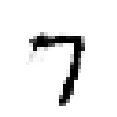

In [276]:
gerar_digito(n_ex=1)

## Transformar a imagem em um array de pixels

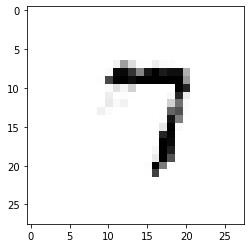

In [280]:
image_list = '/content/digito_gerado.png'
array_list = tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(image_list, color_mode='grayscale', target_size=(28,28))).reshape(1,784).astype(np.int32)

plt.imshow(array_list.reshape(28,28), cmap='gray')
plt.show()

In [133]:
mLink = 'https://github.com/diegonogare/MachineLearning/blob/main/modelo_dt_mnist.pkl?raw=true'
mfile = BytesIO(requests.get(mLink).content)
modelo_dt = joblib.load(mfile)

mLink = 'https://github.com/diegonogare/MachineLearning/blob/main/modelo_knn_mnist.pkl?raw=true'
mfile = BytesIO(requests.get(mLink).content)
modelo_knn = joblib.load(mfile)

mLink = 'https://github.com/diegonogare/MachineLearning/blob/main/modelo_mlp_mnist.pkl?raw=true'
mfile = BytesIO(requests.get(mLink).content)
modelo_mlp = joblib.load(mfile)

Distribuição dos pixels originalmente: (28, 28)
Distribuição dos pixels redistribuído para 28X28: (28, 28)
No dataset, representa o numero: 6


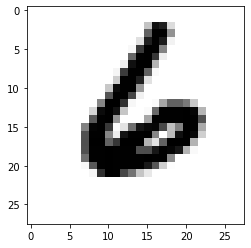

In [282]:
indice = 8888

digito = X_test[indice]
print("Distribuição dos pixels originalmente: " + str(digito.shape))

digito = digito.reshape(28,28)
print("Distribuição dos pixels redistribuído para 28X28: " + str(digito.shape))

print("No dataset, representa o numero: %d" % y_test[indice])

plt.imshow(digito, cmap=matplotlib.cm.binary)
plt.savefig("digito_gerado.png")
plt.show()

digito = digito.reshape(1,784)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  59
  239 223  35   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0 156 253 253 109   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   31 224 253 228  13   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   7 197 254 253 123   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0 152 253 254 200  18   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0  19 239 254 255  76   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0  10 196 253 253 158   6   0   0 

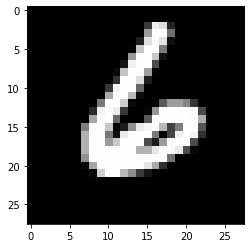

Com Decisin Tree o modelo identificou:  [6]
Com KNN o modelo identificou:  [6]
Com MultiLayer Perceptron o modelo identificou:  [6]


In [283]:
#digito = (array_list)
#digito = abs(digito-255)
digito = digito.astype(np.int32)
print(digito)

plt.imshow(digito.reshape(28,28), cmap='gray')
plt.show()

predicao_dt = modelo_dt.predict(digito)
predicao_dt = predicao_dt.astype(np.int64)

predicao_knn = modelo_knn.predict(digito)
predicao_knn = predicao_knn.astype(np.int64)

predicao_mlp = modelo_mlp.predict(digito)
predicao_mlp = predicao_mlp.astype(np.int64)

print("Com Decisin Tree o modelo identificou: ", predicao_dt);
print("Com KNN o modelo identificou: ", predicao_knn);
print("Com MultiLayer Perceptron o modelo identificou: ", predicao_mlp);